In [1]:
from simforest import SimilarityForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from simforest.utils import create_correlated_feature
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

SEED = 42

import warnings
warnings.filterwarnings('ignore')

# Read the data

In [2]:
X, y = load_svmlight_file('data/heart')
X = X.toarray().astype(np.float32)


features = [f'f{i+1}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns = features)
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0


# Add new feature

Create synthetic column, strongly correlated with target.
Each value is calculated according to the formula:
    v = y * a + random(-b, b)
    So its scaled target value with some noise.

Then a fraction of values is permuted, to reduce the correlation.

In this case, a=10, b=5, fraction=0.1

In [3]:
new_feature, corr, p = create_correlated_feature(y, fraction=0.1, seed=SEED, verbose=True)

Initial new feature correlation, without shuffling: 0.962, p: 0.0
Initial new feature correlation, without shuffling: 0.886, p: 0.0


In [4]:
df = pd.concat([pd.Series(new_feature, name='new_feature'), df], axis=1)
df.head()

,new_feature,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,8.745401,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0
1,-5.492857,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0
2,12.319939,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0
3,-9.013415,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
4,-13.439814,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0


# Split and preprocess the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest

Random Forest performance improved (compared to average f1 score 0.849). We can see that the prediction is vased almost solely on a new feature.

In [6]:
rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print(f'Random Forest f1 score: {round(f1_score(y_test, rf_pred), 3)}')

Random Forest f1 score: 0.955


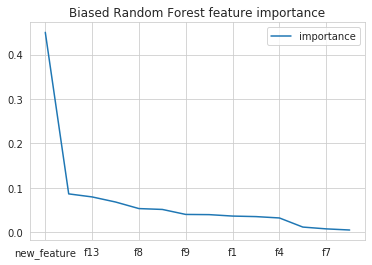

In [7]:
df_rf_importances = pd.DataFrame(rf.feature_importances_, index=df.columns.values, columns=['importance'])
df_rf_importances = df_rf_importances.sort_values(by='importance', ascending=False)
df_rf_importances.plot()
plt.title('Biased Random Forest feature importance');

# Similarity Forest

Similarity Forest's score also improved

In [8]:
sf = SimilarityForestClassifier(n_estimators=100, random_state=SEED)
sf.fit(X_train, y_train)
sf_pred = sf.predict(X_test)

print(f'Similarity Forest f1 score: {round(f1_score(y_test, sf_pred), 3)}')

Similarity Forest f1 score: 0.927


In [9]:
x = [0.0, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.12, 0.15, 0.18, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

correlations = np.zeros(len(x), dtype=np.float32)
rf_scores = np.zeros(len(x), dtype=np.float32)
sf_scores = np.zeros(len(x), dtype=np.float32)

for i, xi in enumerate(x):
    df.pop('new_feature')
    
    # Add new_features
    new_feature, correlations[i], _ = create_correlated_feature(y, fraction=xi, seed=SEED)
    df = pd.concat([pd.Series(new_feature, name='new_feature'), df], axis=1)
    
    # Split the data with random seed
    X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=SEED)

    # Preprocess
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Score Random Forest
    rf1 = RandomForestClassifier(random_state=SEED)
    rf1.fit(X_train, y_train)
    rf1_pred = rf1.predict(X_test)
    
    rf2 = RandomForestClassifier(random_state=0)
    rf2.fit(X_train, y_train)
    rf2_pred = rf2.predict(X_test)
    
    rf_scores[i] = (f1_score(y_test, rf1_pred) + f1_score(y_test, rf2_pred)) / 2
    
    # Score Similarity Forest
    sf1 = SimilarityForestClassifier(n_estimators=100, random_state=SEED)
    sf1.fit(X_train, y_train)
    sf1_pred = sf1.predict(X_test)
    
    sf2 = SimilarityForestClassifier(n_estimators=100, random_state=0)
    sf2.fit(X_train, y_train)
    sf2_pred = sf2.predict(X_test)
    
    sf_scores[i] = (f1_score(y_test, sf1_pred) + f1_score(y_test, sf2_pred)) / 2

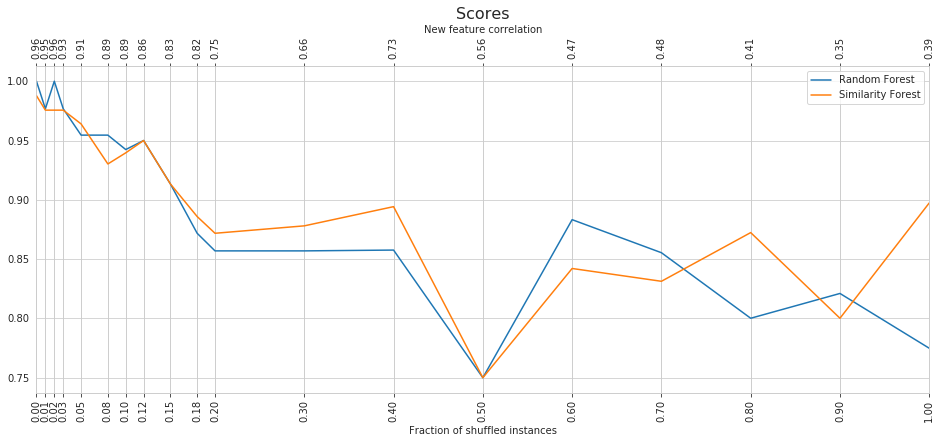

In [11]:
def tick_function():
    return [round(c, 2) for c in correlations]

# Set figure and first axis
fig, ax1 = plt.subplots(figsize=(16, 6))
plt.xticks(rotation=90)
ax1.set_xticks(x)
ax1.set_xlim(0.0, 1.0)
ax1.set_xlabel('Fraction of shuffled instances')

# Set second axis
ax2 = ax1.twiny()
plt.xticks(rotation=90)
ax2.set_xticks(ax1.get_xticks())
ax2.set_xlim(0.0, 1.0)
ax2.set_xticklabels(tick_function())
ax2.set_xlabel('New feature correlation')

# Plot
plt.plot(x, rf_scores, label='Random Forest')
plt.plot(x, sf_scores, label='Similarity Forest')

# Set legend and titles
plt.legend()
plt.ylabel('Score')
plt.title('Scores', fontsize=16);